In [1]:
import numpy as np 
import pandas as pd 
import mglearn 
import matplotlib.pyplot as plt 
%matplotlib inline

## Univarite Statistics


In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split


cancer=load_breast_cancer()
#get deterministic random numbers
rng=np.random.RandomState(42)
noise=rng.normal(size=(len(cancer.data),50))
#add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise=np.hstack([cancer.data,noise])

X_train,X_test, y_train, y_test=train_test_split(
    X_w_noise,cancer.target,random_state=0,test_size=.5
)
# use f_classif (the default) and SelectPercentile to select 50% of features
select=SelectPercentile(percentile=50)
select.fit(X_train,y_train)
# transform training set
X_train_selected=select.transform(X_train)

print("X_train.shape:{}".format(X_train.shape))
print("X_train_selected.shape:{}".format(X_train_selected.shape))


X_train.shape:(284, 80)
X_train_selected.shape:(284, 40)


[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


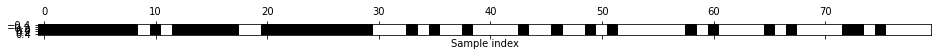

In [3]:
mask=select.get_support()
print(mask)
# visualze the mask --black is true, white is false
plt.matshow(mask.reshape(1,-1),cmap='gray_r')
plt.xlabel('Sample index')
plt.show()

In [4]:
from sklearn.linear_model import LogisticRegression

#transform test data
X_test_selected=select.transform(X_test)

lr=LogisticRegression()
lr.fit(X_train,y_train)
print("score with all features: {:.3f}".format(lr.score(X_test,y_test)))

lr.fit(X_train_selected,y_train)
print("score with selected features: {:.3f}".format(lr.score(X_test_selected,y_test)))

score with all features: 0.916
score with selected features: 0.919


## Model-Based Feature Selection

In [5]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select=SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),threshold='median')

In [6]:
select.fit(X_train,y_train)
X_train_l1=select.transform(X_train)
print("X_train.shape:{}".format(X_train.shape))
print("X_train_l1,shape:{}".format(X_train_l1.shape))

X_train.shape:(284, 80)
X_train_l1,shape:(284, 40)


[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False  True False
 False False False False  True False False  True False  True  True False
 False False  True False False  True  True False False False False False
 False  True False False False False False False False  True False False
 False  True False False False False False False]


Text(0.5, 0, 'Sample index')

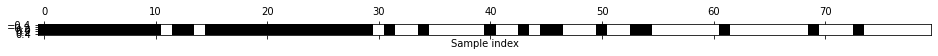

In [7]:
mask=select.get_support()
print(mask)
#Visualize the mask --black is True, white is False
plt.matshow(mask.reshape(1,-1),cmap='gray_r')
plt.xlabel("Sample index")


In [8]:
X_test_l1=select.transform(X_test)
score=LogisticRegression().fit(X_train_l1,y_train).score(X_test_l1,y_test)
print("Test Score: {:.3f}".format(score))

Test Score: 0.930


## Iterative Feature Selection


Text(0.5, 0, 'Sample Index')

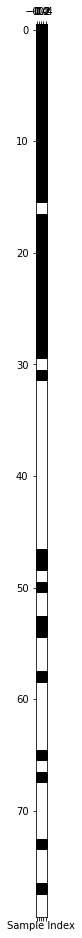

In [11]:
from sklearn.feature_selection import RFE 
select=RFE(RandomForestClassifier(n_estimators=100,random_state=42),n_features_to_select=40)

select.fit(X_train,y_train)
# visualize the selected features:
mask=select.get_support()
plt.matshow(mask.reshape(-1,1),cmap='gray_r')
plt.xlabel("Sample Index")

In [13]:
X_train_rfe=select.transform(X_train)
X_test_rfe=select.transform(X_test)

score=LogisticRegression().fit(X_train_rfe,y_train).score(X_test_rfe,y_test)

print("test score:{:.3f}".format(score))

test score:0.930


In [14]:
print("test score:{:.3f}".format(select.score(X_test,y_test)))

test score:0.951


# Utilizing Expert Knowledge

In [15]:
citibike=mglearn.datasets.load_citibike()
print("The citibike dataset:\n{}".format(citibike.head()))

The citibike dataset:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


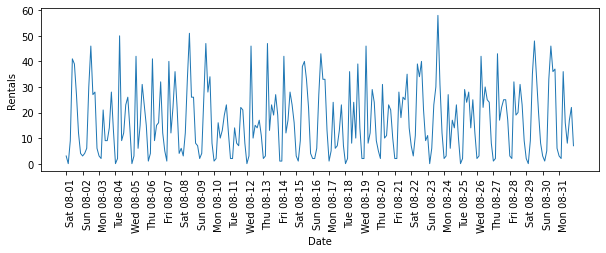

In [16]:
plt.figure(figsize=(10,3))
xticks=pd.date_range(start=citibike.index.min(),end=citibike.index.max())
plt.xticks(xticks,xticks.strftime("%a %m-%d"),rotation=90,ha='left')
plt.plot(citibike,linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")
plt.show()

In [25]:
# extract the target values (number of rentals)
y=citibike.values
#convert the time to POSIX time using %s
X=citibike.index.strftime("%s").astype("int")
X=np.array(X)
X=X.reshape(-1,1)

In [26]:
# use the first 184 points for training, and the rest for testing
n_train=184

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features,target,regressor):
    # split the given features into a training and a test set
    X_train,X_test=features[:n_train],features[n_train:]
    y_train,y_test=target[:n_train],target[n_train:]
    regressor.fit(X_train,y_train)
    print("test-set R^2: {:.2f}".format(regressor.score(X_test,y_test)))
    y_pred=regressor.predict(X_test)
    y_pred_train=regressor.predict(X_train)
    plt.figure(figsize=(10,3))
    plt.xticks(range(0,len(X),8),xticks.strftime("%a %m-%d"),rotation=90,ha='left')

    plt.plot(range(n_train),y_train,label='train')
    plt.plot(range((n_train),len(y_test)+n_train),y_test,'-',label="test")
    plt.plot(range(n_train),y_pred_train,'--',label='prediction train')
    plt.plot(range((n_train),len(y_test)+n_train),y_pred,'--',label='prediction test')
    plt.legend(loc=(1.01,0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")
    plt.show()

test-set R^2: -0.04


<Figure size 432x288 with 0 Axes>

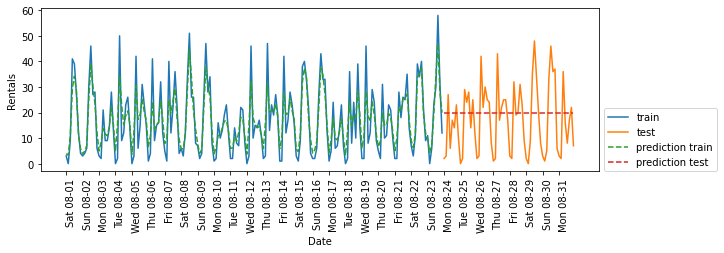

In [27]:
from sklearn.ensemble import RandomForestRegressor
regressor=RandomForestRegressor(n_estimators=100,random_state=0)
plt.figure()
eval_on_features(X,y,regressor)

test-set R^2: 0.60


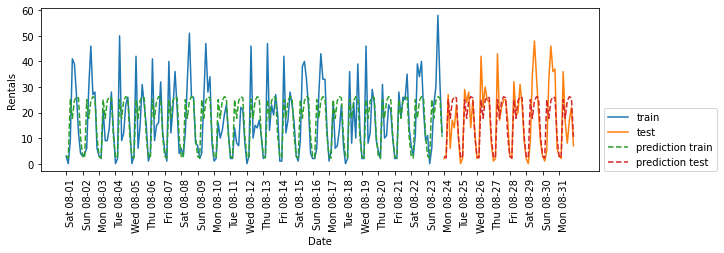

In [30]:
X_hour=citibike.index.hour
X_hour=np.array(X_hour).reshape(-1,1)
eval_on_features(X_hour,y,regressor)

test-set R^2: 0.84


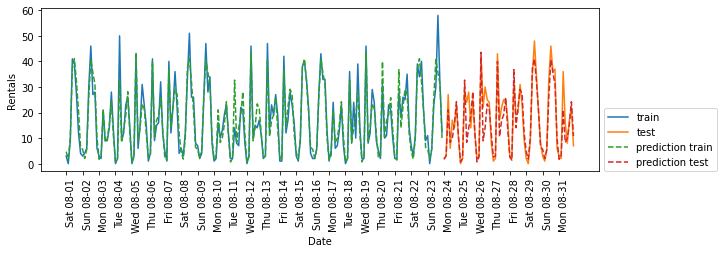

In [31]:
X_hour_week=np.hstack([np.array(citibike.index.dayofweek).reshape(-1,1),np.array(citibike.index.hour).reshape(-1,1)])
eval_on_features(X_hour_week,y,regressor)

test-set R^2: 0.13


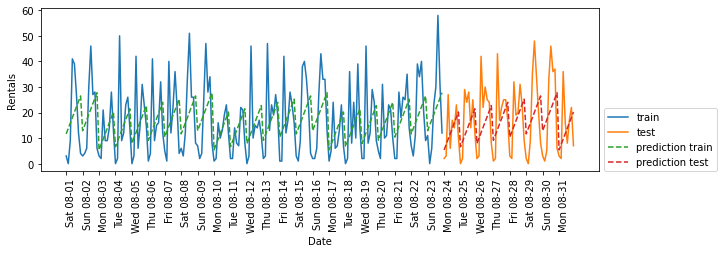

In [32]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week,y,LinearRegression())

test-set R^2: 0.62


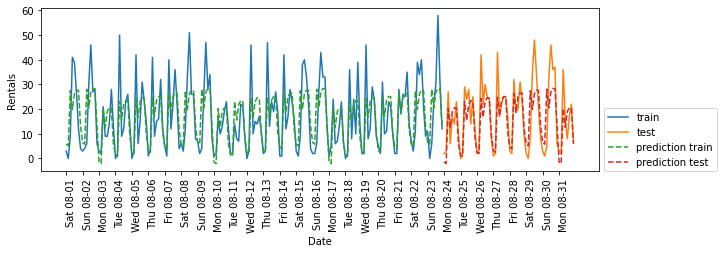

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
enc=OneHotEncoder()
X_hour_week_onehot=enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot,y,Ridge())

test-set R^2: 0.85


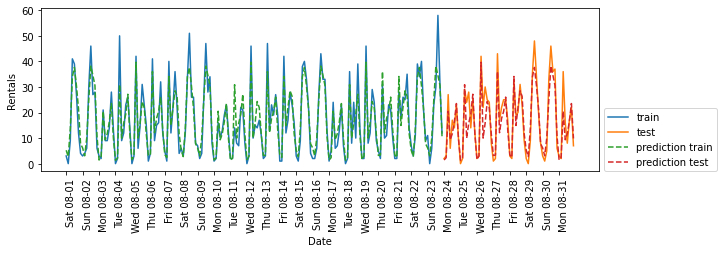

In [35]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer=PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)

X_hour_week_onehot_poly=poly_transformer.fit_transform(X_hour_week_onehot)
lr=Ridge()
eval_on_features(X_hour_week_onehot_poly,y,lr)

In [36]:
hour=["%02d:00" % i for i in range(0,24,3)]
day=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
feature=day+hour

In [37]:
features_poly=poly_transformer.get_feature_names(feature)
features_nonzero=np.array(features_poly)[lr.coef_!=0]
coef_nonzero=lr.coef_[lr.coef_!=0]

Text(0, 0.5, 'Feature')

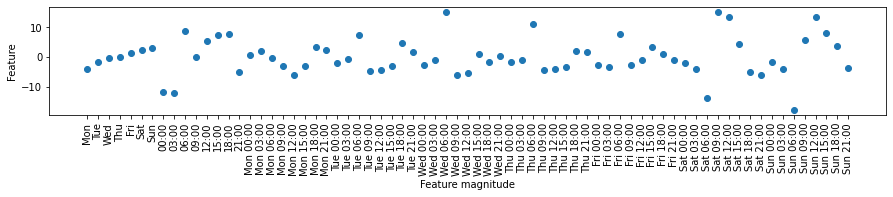

In [38]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature magnitude")
plt.ylabel("Feature")